In [56]:
!git clone https://github.com/utkuozbulak/pytorch-cnn-visualizations.git

fatal: destination path 'pytorch-cnn-visualizations' already exists and is not an empty directory.


In [47]:
import sys
sys.path.insert(0, 'pytorch-cnn-visualizations/src')


In [54]:
# credit to Utku Ozbulakimport os
import numpy as np

import torch
from torch.optim import Adam
from torchvision import models
import matplotlib.pyplot as plt

from misc_functions import preprocess_image, recreate_image, save_image


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            # print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(str(loss.data.numpy())))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            plt.imshow(self.created_image)
            plt.show()
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            plt.imshow(self.created_image)
            
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

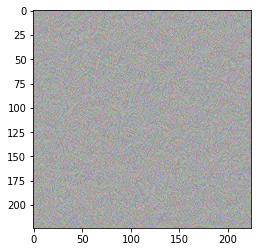

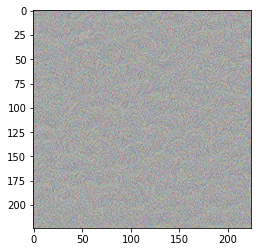

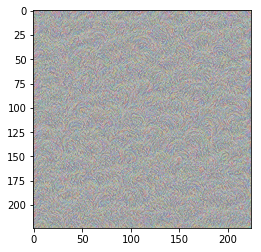

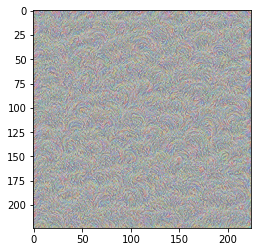

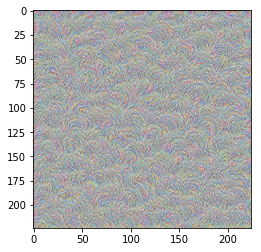

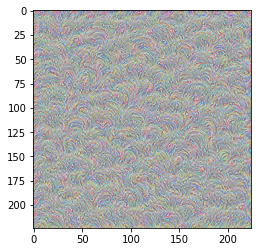

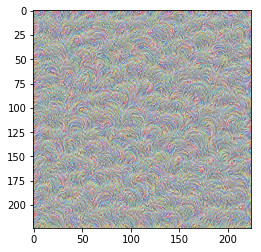

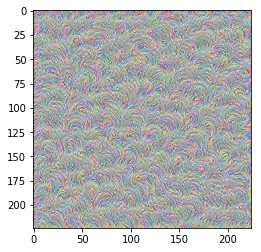

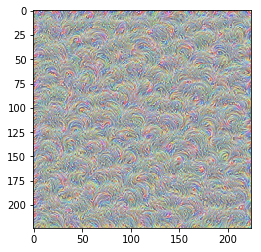

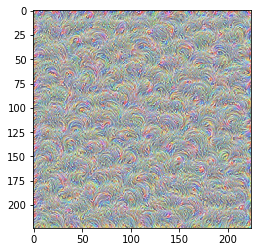

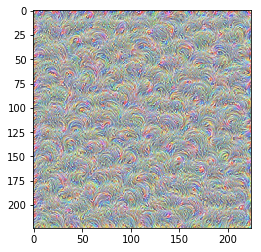

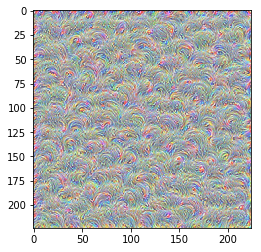

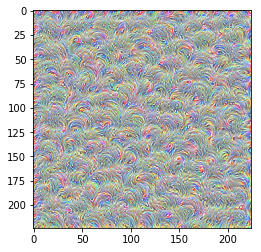

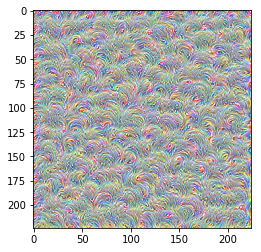

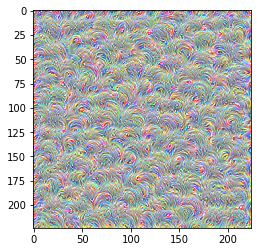

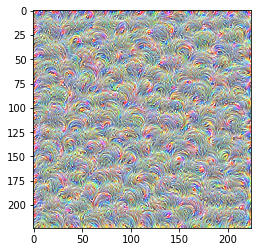

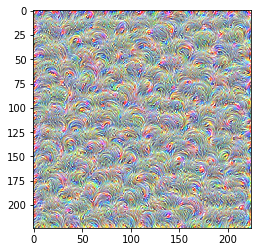

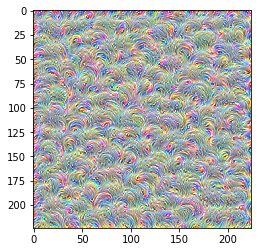

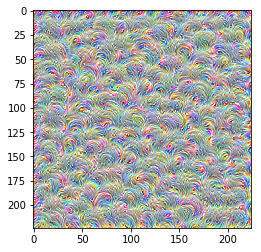

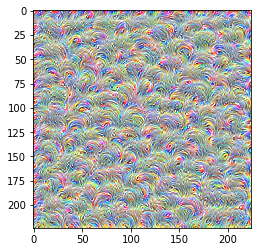

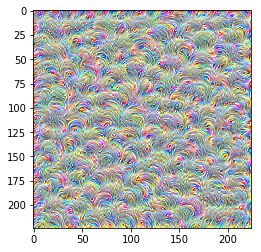

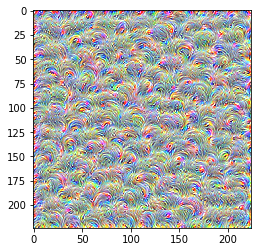

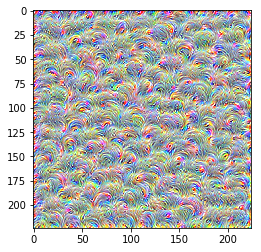

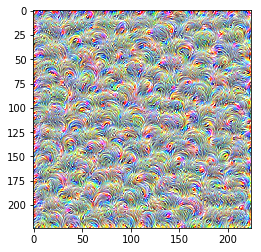

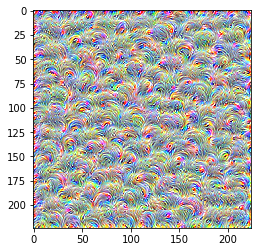

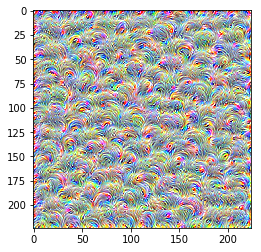

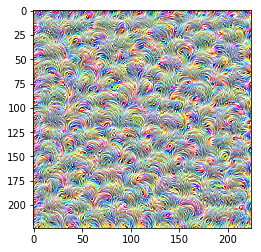

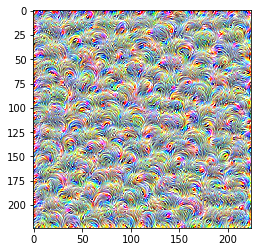

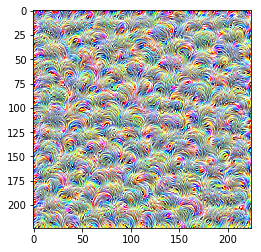

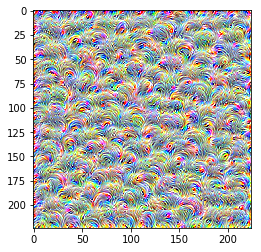

In [55]:
cnn_layer = 17
filter_pos = 5
# Fully connected layer is not needed
pretrained_model = models.vgg16(pretrained=True).features
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
# layer_vis.visualise_layer_without_hooks()